In [1]:
import sys
sys.path.append("/home/salmon/workspace/fytok/python")
sys.path.append("/home/salmon/workspace/SpDev/SpCommon")
sys.path.append("/home/salmon/workspace/SpDev/SpDB")

import collections
from spdm.util.logger import logger
from spdm.data.Collection import Collection
import matplotlib.pyplot as plt
import numpy as np
from scipy import special
import math

In [2]:
db = Collection("EAST:///home/salmon/public_data/~t/",default_tree_name="efit_east")
entry = db.open(shot=55555).entry

2020-10-22 09:22:03,140 DEBUG [spdm] /home/salmon/workspace/SpDev/SpCommon/spdm/util/sp_export.py:73:sp_find_module: spdm.data.plugins.PluginEAST#EASTCollection
2020-10-22 09:22:03,141 INFO [spdm] /home/salmon/workspace/SpDev/SpDB/spdm/data/Plugin.py:70:find_plugin: Load Plugin: EASTCollection
2020-10-22 09:22:03,175 DEBUG [spdm] /home/salmon/workspace/SpDev/SpCommon/spdm/util/sp_export.py:73:sp_find_module: spdm.data.plugins.PluginMDSplus#MDSplusCollection
2020-10-22 09:22:03,178 INFO [spdm] /home/salmon/workspace/SpDev/SpDB/spdm/data/Plugin.py:70:find_plugin: Load Plugin: MDSplusCollection
2020-10-22 09:22:03,180 DEBUG [spdm] /home/salmon/workspace/SpDev/SpDB/spdm/data/Collection.py:49:__init__: Open MDSplusCollection : mdsplus:///home/salmon/public_data/~t/
2020-10-22 09:22:03,181 DEBUG [spdm] /home/salmon/workspace/SpDev/SpDB/spdm/data/Collection.py:49:__init__: Open EASTCollection : URISplitResult(schema='EAST', authority='', path='/home/salmon/public_data/~t/', query=None, fragme

In [3]:


vessel_inner_points= np.array([entry.wall.description_2d.vessel.annular.outline_inner.r.__value__(),    
                                          entry.wall.description_2d.vessel.annular.outline_inner.z.__value__()]).transpose([1,0]) 

vessel_outer_points= np.array([entry.wall.description_2d.vessel.annular.outline_outer.r.__value__(),    
                                          entry.wall.description_2d.vessel.annular.outline_outer.z.__value__()]).transpose([1,0])  

limiter_points =  np.array([entry.wall.description_2d[0].limiter.unit[0].outline.r.__value__(),
                                 entry.wall.description_2d[0].limiter.unit[0].outline.z.__value__()]).transpose([1,0]) 




2020-10-22 09:22:07,918 DEBUG [spdm] /home/salmon/workspace/SpDev/SpDB/spdm/data/plugins/PluginMDSplus.py:45:open_mdstree: Opend MDSTree: pcs_east 55555 mode="NORMAL"


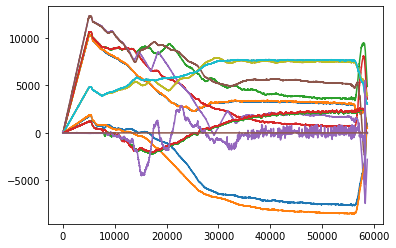

In [4]:
 
for coil  in entry.pf_active.coil:
    plt.plot(coil.current.data.__value__())
    


In [5]:
COIL=collections.namedtuple("COIL", "label r z current")
def psi(r, z, coils):
    def green_function(Rc, Zc, R, Z):
        k2   =  4.0*Rc*R/((Rc+R)*(Rc+R)+(Zc-Z)*(Zc-Z))          
        return   math.sqrt(R*Rc)/(2.0*math.pi)* ((2.0-k2) * special.ellipk(k2) - 2.0* special.ellipe(k2))/math.sqrt(k2)  
    return sum([green_function(coil.r, coil.z, r, z)*coil.current for coil in coils])

In [6]:
itime=30000

pf_coils=[] 
rpos=[]
zpos=[]
 
itime=40000
for coil in entry.pf_active.coil: 
  
    # coil=entry.pf_active.coil[idx+1]
    rect=coil.element[0].geometry.rectangle.__value__()
    rpos.append(rect.r-rect.width/2.0)
    rpos.append(rect.r+rect.width/2.0)
    zpos.append(rect.z-rect.height/2.0)
    zpos.append(rect.z+rect.height/2.0)  
    pf_coils.append(COIL(coil.name.__value__(),
     rect.r*1.0,rect.z*1.0, coil.current.data.__value__()[itime]* (coil.element[0].turns_with_sign*1 ) ))
    # pf_coils.append(COIL(rect.r*1.0,rect.z*1.0,Ic[idx] ) )
    # print((idx,coil.name.__value__()))

rmin=min(rpos)
rmax=max(rpos)
zmin=min(zpos)
zmax=max(zpos)

# pf_coils.append(COIL(
#     (rmin+rmax)/2.0,0.0,
#       -500000.0)
# )



NX=100
NY=100
X, Y  = np.meshgrid(np.linspace(rmin, rmax, NX),np.linspace(zmin, zmax, NY))
Z=np.ndarray([NX,NY])
for ix in range(NX):
    for iy in range(NY):
        Z[ix,iy]=psi(X[ix,iy],Y[ix,iy],pf_coils)

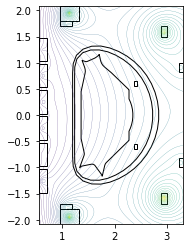

In [7]:
fg=plt.figure()

plt.gca().add_patch(plt.Polygon(limiter_points , fill=False,closed=True))
plt.gca().add_patch(plt.Polygon(vessel_outer_points , fill=False,closed=True))
plt.gca().add_patch(plt.Polygon(vessel_inner_points , fill=False,closed=True))

for coil  in entry.pf_active.coil:
    rect=coil.element[0].geometry.rectangle.__value__() 
    plt.gca().add_patch(plt.Rectangle((rect.r-rect.width/2.0, rect.z-rect.height/2.0), rect.width, rect.height, fill=False))
 
plt.contour(X,Y,Z,levels=40,linewidths=0.2)

# plt.contour(
#     entry.equilibrium.time_slice[10].profiles_2d.grid.dim1.__value__(),
#     entry.equilibrium.time_slice[10].profiles_2d.grid.dim2.__value__(),
#     entry.equilibrium.time_slice[10].profiles_2d.psi.__value__(),
#     linewidths=0.5)

plt.axis('scaled')
plt.show()

In [7]:
sys.path.append("/home/salmon/workspace/freegs/")
import freegs
from freegs.machine import Machine,Wall
import freegs.equilibrium as equilibrium
import freegs.jtor as jtor
import freegs.picard as picard
import freegs.boundary as boundary
from  freegs.coil import Coil

itime=40000
coils = []
for coil in entry.pf_active.coil:
    rect = coil.element[0].geometry.rectangle.__real_value__()
    Ip = coil.current.data.__value__()[itime] 
    turns=coil.element[0].turns_with_sign*1
    coils.append((coil.name.__value__(), Coil(rect["r"], rect["z"],current= Ip*turns,turns=1,control=True)))

wall = Wall(entry.wall.description_2d[0].limiter.unit[0].outline.r.__value__(),
            entry.wall.description_2d[0].limiter.unit[0].outline.z.__value__())

Rdim=entry.equilibrium.time_slice[10].profiles_2d.grid.dim1.__value__()
Zdim=entry.equilibrium.time_slice[10].profiles_2d.grid.dim2.__value__()


EASTTokamak = Machine(coils, wall)

profiles = jtor.ConstrainPaxisIp(1e3,  # Plasma pressure on axis [Pascals]
                            1e6,  # Plasma current [Amps]
                            1.0)  # fvac = R*Bt

psivals = [ (R, Z, 0.0) for R, Z in zip(wall.R,wall.Z)]
# psivals = [ (R, Z, 0.0) for R, Z in zip(entry.equilibrium.time_slice[10].boundary.outline.r.__value__(), 
#             entry.equilibrium.time_slice[10].boundary.outline.z.__value__()) ]

constrain = freegs.control.constrain(psivals=psivals)

rmin=min(Rdim)
rmax=max(Rdim)
zmin=min(Zdim)
zmax=max(Zdim)

eq = equilibrium.Equilibrium(tokamak=EASTTokamak,
                                Rmin=rmin, Rmax=rmax,
                                Zmin=zmin, Zmax=zmax,
                                nx=129, ny=129,
                                boundary=boundary.freeBoundaryHagenow)

freegs.solve(eq, profiles,constrain, psi_bndry=0.0) 


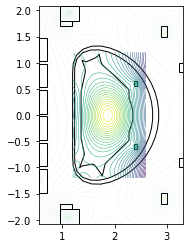

In [8]:
fg=plt.figure()

plt.gca().add_patch(plt.Polygon(limiter_points , fill=False,closed=True))
plt.gca().add_patch(plt.Polygon(vessel_outer_points , fill=False,closed=True))
plt.gca().add_patch(plt.Polygon(vessel_inner_points , fill=False,closed=True))

for coil  in entry.pf_active.coil:
    rect=coil.element[0].geometry.rectangle.__value__() 
    plt.gca().add_patch(plt.Rectangle((rect.r-rect.width/2.0, rect.z-rect.height/2.0), rect.width, rect.height, fill=False))
 
plt.contour(X,Y,Z,levels=40,linewidths=0.1,linestyles="dotted")

# plt.contour(
#     entry.equilibrium.time_slice[10].profiles_2d.grid.dim1.__value__(),
#     entry.equilibrium.time_slice[10].profiles_2d.grid.dim2.__value__(),
#     entry.equilibrium.time_slice[10].profiles_2d.psi.__value__(),
#     linewidths=0.5,cmap="gray")

plt.contour(np.linspace(rmin,rmax,129),np.linspace(zmin,zmax,129),eq.psi().transpose(-1,0),levels= 40,linewidths=0.5)

plt.axis('scaled')
plt.show()

In [ ]:
entry.equilibrium.time_slice[10].boundary.psi.__value__()